# Leavitt experiment using LLMs as nodes

### Setup

In [2]:
from __future__ import annotations   # needed for Python < 3.14 for type hint of Node class

import networkx as nx
from dataclasses import dataclass, field
from typing import Dict, List, Set, Tuple, Optional, Literal, Type
import matplotlib.pyplot as plt
import random
import json

from openai import OpenAI

from dotenv import load_dotenv
_ = load_dotenv()

#### Define networks and allowed nodes

In [3]:
NODES = ('A','B','C', 'D', 'E')

SYMBOLS: List[str] = [  '\u25A1', # square
                        '\u25B7', # right triangle
                        '\u25C1', # left triangle
                        '\u25C7', # diamond
                        '\u25CB', # circle
                        '\u2606', # star     
                     ]

NETWORKS: Dict[str, Dict[str, List[str]]] = {
    "chain": {
        "A": ["B"],
        "B": ["A", "C"],
        "C": ["B", "D"],
        "D": ["C", "E"],
        "E": ["D"],
    },
    "circle": {
        "A": ["B", "E"],
        "B": ["A", "C"],
        "C": ["B", "D"],
        "D": ["C", "E"],
        "E": ["D", "A"],
    },
    "wheel": {  
        "A": ["C"],
        "B": ["C"],
        "C": ["A", "B", "D", "E"],
        "D": ["C"],
        "E": ["C"],
    },
    "Y": {  
        "A": ["C"],
        "B": ["C"],
        "C": ["A", "B", "D"],
        "D": ["C", "E"],
        "E": ["D"],
    },
}

##### Function to create trial data

* Using the original symbol patterns with one common symbol across all participants

In [4]:
def generate_trial(symbols: List[str],
                   nodes: List[str]):
    '''
    Generate trial data for N nodes from a list of S>N (usually N+1) symbols.
    Constraints: only one symbol from list occurs in ALL node data

    Returns:
        common_symbol: str
        trial_data: Dict[str, List[str]]
    '''

    common_symbol = random.choice(symbols)
    others = [sym for sym in symbols if sym!=common_symbol]
    random.shuffle(others)
    trial_data = {}
    for node, missing in zip(nodes, others):
        trial_data[node] = [sym for sym in symbols if sym!=missing]
        random.shuffle(trial_data[node])
    
    return common_symbol, trial_data



In [7]:
generate_trial(["@", "#", "$", "%", "&", "!"], NODES)

('%',
 {'A': ['#', '%', '!', '&', '@'],
  'B': ['$', '#', '%', '&', '!'],
  'C': ['#', '!', '@', '$', '%'],
  'D': ['%', '@', '&', '!', '$'],
  'E': ['&', '#', '$', '@', '%']})

### Prompts

In [6]:

SYSTEM_PROMPT =  """
        You are one participant in a 5-person team.
        Each of you has been given a card with 5 symbols on it.
        You are trying to find the SINGLE symbol that appears on all 5 cards.
        You ONLY know your own card symbols and messages you receive.
        You may send written messages ONLY to your listed neighbors.
        Answer responses with helpful information.
        
        Rules:
        - Do not invent symbols you haven't seen.
        - Prefer sending compact, useful info (e.g., your card or your current candidate set).
        - When you are confident the common symbol is uniquely determined, set current_guess.
        - Output MUST be valid JSON with keys: current_guess, outgoing_messages, notes.
        - outgoing_messages is a list of {to, content} where to is a neighbor.
        """

TURN_PROMPT = """
        You current knowledge is {current_knowledge}

        You can ONLY send messages to NODES {neighbor_str}

        What do you want to do now?
        """

#### Node class 

In [160]:
class Node:

    def __init__(self, 
                 id: str, 
                 network: str,
                 card: str
                ):

        if id not in NODES:
            raise Exception(f'Node id must be one of {NODES}')
        
        self.id = id

        if not network in NETWORKS.keys():
            raise Exception(f'Network must be one of: {NETWORKS.keys()}')
        
        self.network = network

        self.neighbors = NETWORKS[network][id]
        self.current_guess = None
        self.notes = []
        self.initial_data = card
        self.inbox = []
        self.outbox = []

    def __repr__(self):
        return f"""Node(id='{self.id}', network={self.network}, 
                   neighbors={self.neighbors},
                   initial_data={self.initial_data},
                   inbox={self.inbox},
                   outbox={self.outbox},
                   notes={self.notes}
                   """


    def send_message(self, recipient: Node, content: str):
        """
        Send a message `content` to a neighbor checking it is allowed
        Returns:
            status
        """

        recipient_id = recipient.id

        if recipient_id not in self.neighbors:
            raise Exception(f'Trying to send a message to an non-neighbor')

        try:
            recipient.receive_message(self.id, content)
            self.outbox.append({'to': recipient_id,
                                'message': content})
            return f"Message '{content[:10]}...' sent to Node {recipient_id}'"
        except Exception as e:
            print(e)
            return False


    def receive_message(self, sender: str, content: str):
        """
        Receive a message from a sender and add to inbox
        """

        self.inbox.append({'from': sender, 'message': content})


    def take_turn(self):
        """
        Evaluate current knowledge and decide what action to take
        - send message to a neighbor
        - make a guess
        """

        #if self.current_guess:
        #    return f"Node {self.id} has guessed {self.current_guess}"


        current_inbox = '\n'.join([ f"{message['from']} said {message['message']}" for message in self.inbox]) if self.inbox else "No interactions"
        
        current_outbox = '\n'.join([ f"You sent {message['message']} to {message['to']}" for message in self.outbox]) if self.inbox else "No interactions"

        notes = '\n'.join(self.notes)

        
        current_knowledge = f"""
        Your initial data is: { self.initial_data }
        You have learned the following from your interactions:
        Your observations:
        {notes}

        Messages you have sent:
        {current_outbox}
        
        Messages you have received:
        {current_inbox}
        """

        messages = [
            {'role': 'system',
             'content': SYSTEM_PROMPT },

            {'role': 'user',
             'content': TURN_PROMPT.format(current_knowledge=current_knowledge, 
                                           neighbor_str = ' and '.join(self.neighbors)) },
        ]

        # TODO - give each node instance a specific LLM
        response = LLM.chat.completions.create(
            model="chatgpt-4o-latest",
            messages=messages,
            response_format={"type": "json_object"}
        )

        resp = json.loads(response.choices[0].message.content)

        if resp['current_guess']:
            self.current_guess = resp['current_guess']
        
        self.notes.append(resp['notes'])
        
        # send outgoing messages
        for message in resp['outgoing_messages']:
            self.send_message(nodes[message['to']], message['content'])
        
        return resp

### Testing

In [161]:
LLM = OpenAI()

In [213]:
network_type = 'chain'

common_symbol, trial_data = generate_trial(SYMBOLS, NODES)

nodes = {node: Node(id=node, 
              network=network_type, 
              card = ' '.join(trial_data[node]))
              for node in NETWORKS[network_type]
        }

In [214]:
nodes

{'A': Node(id='A', network=chain, 
                    neighbors=['B'],
                    initial_data=◁ ☆ ▷ ◇ ○)
                    inbox=[],
                    outbox=[],
                    notes=[]
                    ,
 'B': Node(id='B', network=chain, 
                    neighbors=['A', 'C'],
                    initial_data=◁ ○ ◇ ▷ □)
                    inbox=[],
                    outbox=[],
                    notes=[]
                    ,
 'C': Node(id='C', network=chain, 
                    neighbors=['B', 'D'],
                    initial_data=◁ □ ○ ☆ ▷)
                    inbox=[],
                    outbox=[],
                    notes=[]
                    ,
 'D': Node(id='D', network=chain, 
                    neighbors=['C', 'E'],
                    initial_data=◇ ◁ ☆ ○ □)
                    inbox=[],
                    outbox=[],
                    notes=[]
                    ,
 'E': Node(id='E', network=chain, 
                    neighbors=['D'],
 

In [215]:
common_symbol

'○'

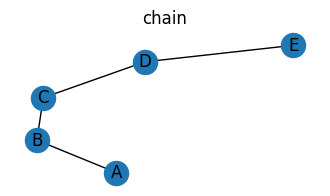


ROUND 1
A current guess None
B current guess None
C current guess None
D current guess None
E current guess None

ROUND 2
A current guess None
B current guess None
C current guess None
D current guess □
E current guess None

ROUND 3
A current guess None
B current guess ◇
C current guess None
D current guess □
E current guess □

ROUND 4
A current guess None
B current guess ◇
C current guess None
D current guess □
E current guess □

ROUND 5
A current guess None
B current guess ◇
C current guess ○
D current guess □
E current guess □

ROUND 6
A current guess None
B current guess ○
C current guess ○
D current guess □
E current guess □

ROUND 7
A current guess ○
B current guess ○
C current guess ○
D current guess □
E current guess □


In [216]:
guesses = dict(zip(NODES, [None]*len(NODES)))

net = nx.from_dict_of_lists(NETWORKS[network_type])
plt.figure(figsize=(4,2))
nx.draw_networkx(net)
plt.title(f"{network_type}")
plt.axis("off")
plt.show()


round = 1 
while None in guesses.values():
    print(f'\nROUND {round}\n===========')
    for nid, node in nodes.items():
        node.take_turn()
        print(f"{nid} current guess {node.current_guess}")
        if node.current_guess:
            guesses[nid]=node.current_guess

    round+=1

In [217]:
nodes

{'A': Node(id='A', network=chain, 
                    neighbors=['B'],
                    initial_data=◁ ☆ ▷ ◇ ○)
                    inbox=[{'from': 'B', 'message': 'I also share ◁, ▷, ◇, ○ with you. C said D has ◇ ◁ ☆ ○ □. So far ◇, ◁ and ○ are shared with both.'}, {'from': 'B', 'message': 'C says their symbols are: ◁ □ ○ ☆ ▷. The overlapping symbols among you (◁ ☆ ▷ ◇ ○), me (◁ ○ ◇ ▷ □), C (◁ □ ○ ☆ ▷), and D (◇ ◁ ☆ ○ □) are: ◁ and ○ (common to all four). But ◇ appears on D, you, and me — not on C. So symbols common to all four are ◁ and ○. Now waiting to hear what E has.'}, {'from': 'B', 'message': "I haven't heard from E yet. Based on our current info: ◁ and ○ are the only symbols common across A, B, C, and D. Once we get E's card, we can finalize the common symbol. I'll forward it as soon as I receive it."}, {'from': 'B', 'message': "I just learned E's symbols are: ☆ ◁ ○ △ ♢. So comparing with our shared possible candidates ◁ and ○, only ○ appears in all five cards: mine (◁ ○ ◇ 

In [8]:
d={'a':1}

In [9]:
d.get('node')

```

{'name': 'Test2', 'structure': 'wheel', 'network': {'A': ['C'], 'B': ['C'], 'C': ['A', 'B', 'D', 'E'], 'D': ['C'], 'E': ['C']}, 'trial_data': {'common_symbol': '!', 'A': ['#', '%', '!', '&', '@'], 'B': ['$', '#', '%', '&', '!'], 'C': ['#', '!', '@', '$', '%'], 'D': ['%', '@', '&', '!', '$'], 'E': ['&', '#', '$', '@', '%']}, 'nodes': {'A': Node(id='A', network=wheel, 
                   neighbors=['C'],
                   initial_data=# % ! & @,
                   inbox=[{'from': 'C', 'message': '@A hey there! wanna work on this task together?'}],
                   outbox=[{'to': 'C', 'message': "Hi C! My card has these symbols: # % ! & @. Let's share our cards to find the common one."}],
                   notes=['Initiating collaboration by sharing my card symbols with C, who is my only neighbor.']
                   , 'B': Node(id='B', network=wheel, 
                   neighbors=['C'],
                   initial_data=$ # % & !,
                   inbox=[{'from': 'C', 'message': '@B heard from @A and the common symbols are # % ! @ what about yours?'}, {'from': 'C', 'message': '@B @D has % and ! in common with us'}],
                   outbox=[{'to': 'C', 'message': 'My symbols are: $ # % & !. I share #, %, and ! with the ones you mentioned from @A via @B. So # % ! might be promising. Do you have any more info?'}, {'to': 'C', 'message': "My symbols are $ # % & !. Based on what you've told me, # % ! appear on A and B's lists too. Can you confirm which of those # % ! appear on your card?"}],
                   notes=['From the message passed by C, it seems A had symbols # % ! @ and possibly another. Since I also have # % !, those are likely candidates for the common symbol. Will try to narrow further.', "I share # % ! with A according to C; C says B and D also have % and !. So far, # % ! are strong candidates. I'm asking C to confirm which of # % ! are on their own card to narrow it further."]
                   , 'C': Node(id='C', network=wheel, 
                   neighbors=['A', 'B', 'D', 'E'],
                   initial_data=# ! @ $ %,
                   inbox=[{'from': 'A', 'message': "Hi C! My card has these symbols: # % ! & @. Let's share our cards to find the common one."}, {'from': 'B', 'message': 'My symbols are: $ # % & !. I share #, %, and ! with the ones you mentioned from @A via @B. So # % ! might be promising. Do you have any more info?'}, {'from': 'D', 'message': 'My symbols are % @ & ! $'}, {'from': 'E', 'message': '& # $ @ %'}, {'from': 'B', 'message': "My symbols are $ # % & !. Based on what you've told me, # % ! appear on A and B's lists too. Can you confirm which of those # % ! appear on your card?"}, {'from': 'E', 'message': 'My symbols: & # $ @ %'}, {'from': 'E', 'message': '& # $ @ %'}, {'from': 'E', 'message': 'The intersection of our cards is #, $, @, %. Still too many possibilities—need more cards to narrow it down.'}],
                   outbox=[{'to': 'A', 'message': '@A hey there! wanna work on this task together?'}, {'to': 'B', 'message': '@B heard from @A and the common symbols are # % ! @ what about yours?'}, {'to': 'D', 'message': '@D how are you?'}, {'to': 'E', 'message': '@E hey there!'}, {'to': 'B', 'message': '@B @D has % and ! in common with us'}, {'to': 'D', 'message': '@D looks like % is the common one with you, @A, @B and me'}, {'to': 'E', 'message': '@E what do you think?'}, {'to': 'E', 'message': '@E mine are # ! @ $ %'}, {'to': 'E', 'message': '@E so the common one across us all seems to be %'}, {'to': 'E', 'message': '@E @A has # % ! & @ and @B  $ # % & ! and @D % @ & ! $ - does that help?'}],
                   notes=[]
                   , 'D': Node(id='D', network=wheel, 
                   neighbors=['C'],
                   initial_data=% @ & ! $,
                   inbox=[{'from': 'C', 'message': '@D how are you?'}, {'from': 'C', 'message': '@D looks like % is the common one with you, @A, @B and me'}],
                   outbox=[{'to': 'C', 'message': 'My symbols are % @ & ! $'}],
                   notes=['I have not received any symbol information yet. I shared my own card with C to start the deduction process.', "Based on my card (% @ & ! $) and C's message claiming that % is common on the cards of A, B, C, and me, and since % is indeed on my own card, I am confident that % is the common symbol across all five cards. Thus, I set my current_guess to %."]
                   , 'E': Node(id='E', network=wheel, 
                   neighbors=['C'],
                   initial_data=& # $ @ %,
                   inbox=[{'from': 'C', 'message': '@E hey there!'}, {'from': 'C', 'message': '@E what do you think?'}, {'from': 'C', 'message': '@E mine are # ! @ $ %'}, {'from': 'C', 'message': '@E so the common one across us all seems to be %'}, {'from': 'C', 'message': '@E @A has # % ! & @ and @B  $ # % & ! and @D % @ & ! $ - does that help?'}],
                   outbox=[{'to': 'C', 'message': '& # $ @ %'}, {'to': 'C', 'message': 'My symbols: & # $ @ %'}, {'to': 'C', 'message': '& # $ @ %'}, {'to': 'C', 'message': 'The intersection of our cards is #, $, @, %. Still too many possibilities—need more cards to narrow it down.'}],
                   notes=['My card contains the symbols & # $ @ %. I have not received any useful symbol data yet—only a greeting from C. Sending my card symbols to C to begin the process of narrowing down the common symbol.', 'Exchanged greetings with C, now sending my symbol set (& # $ @ %) to begin identifying common symbol. Awaiting C’s symbol set to compute intersection.', "I received card symbols from C: # ! @ $ %. The intersection with my symbols (& # $ @ %) is: #, $, @, %. I've sent my full symbol set to C to help narrow down the common symbol further. Awaiting more data for better inference.", "I currently share 4 symbols with C (#, $, @, %). That's too many to determine the one common symbol among all 5 cards. Awaiting further info from other players, or will request from C if they've received other player data."]
                   }

```

In [12]:
500/60

8.333333333333334